In [17]:
#se importan las librerias
import cv2
import matplotlib.pyplot as plt
import numpy as np

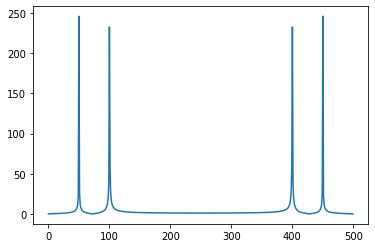

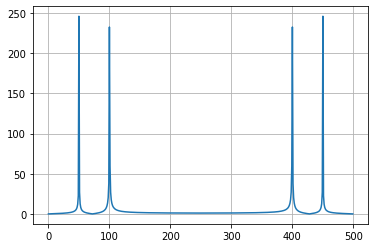

(76.08428018552732+234.16333656488055j)
(76.08428018552732+234.16333656488055j)


In [18]:
#Numero de muestras
N_x=500

#rango en el cual se van a tomar las muestras de la función
a=0
b=2*np.pi
L_x=b-a
#la distancia entre samples es:
delta_x=L_x/N_x

#defino el vector con N entradas igualmente espaciadas, avanzando como n*delta_x donde n es un entero
x=np.linspace(a,b,N_x)

#defino la función objetivo
Funcion=np.sin(50*x)+np.sin(100*x)

#defino el ancho B_x si la señal está bien muestreada:
B_x=N_x/L_x

#defino el vector del espacio de frecuencias que tiene un tamaño B_x, y un paso de 1/L_x
f_x=np.arange(0,B_x,1/L_x)

#vector vacio del tamaño de mi vector de frecuencias 
FFT_Funcion=[0]*len(f_x)

#Fourier transform
for m in range(0,len(f_x)-1):
    for n in range(0,N_x-1):
        FFT_Funcion[m]+=Funcion[n]*np.exp(-1j*2*np.pi*(n*m)/N_x)
        

magnitude=np.angle(FFT_Funcion)
plt.plot(np.abs(FFT_Funcion))
plt.show()

shift_Funcion=[0]*len(f_x)
#Fourier transform
for i in range(0,500):
        shift_Funcion[i] = FFT_Funcion[i]*np.exp(1j*2*0*np.pi/500)
        

plt.plot(np.abs(shift_Funcion))
plt.grid("tiny")
plt.show()
print(FFT_Funcion[450])
print(shift_Funcion[450])

In [19]:
#Defino función DFT

def DFT_1D(Funcion,N):
    #rango en el cual se van a tomar las muestras de la función
    a=0
    b=2*np.pi
    L_x=b-a

    #defino el vector con N entradas igualmente espaciadas, avanzando como n*delta_x donde n es un entero
    #x=np.linspace(a,b,N)

    #defino el ancho B_x si la señal está bien muestreada:
    B_x=N/L_x

    #defino el vector del espacio de frecuencias que tiene un tamaño B_x, y un paso de 1/L_x
    f_x=np.arange(0,B_x,1/L_x)

    #vector vacio del tamaño de mi vector de frecuencias 
    FFT_Funcion=[0]*len(f_x)

    #Fourier transform
    for m in range(0,len(f_x)):
        for n in range(0,N-1):
            FFT_Funcion[m]+=Funcion[n]*np.exp(-1j*2*np.pi*(n*m)/N)

    return FFT_Funcion
    

In [20]:
#Función que genera una onda esferica ideal

def spherical_wave(M,N,dx,dy,z,wavelength):
    #Centros de la imagen
    Mcen = int((M/2))
    Ncen = int((N/2))
   #Arreglos de x y y
    x=np.arange(-Mcen,Mcen+1)
    y=np.arange(-Ncen,Ncen+1)
    #Malla de la matriz
    X, Y = np.meshgrid(x,y)
    #Vector de una onda
    k= 2*np.pi/wavelength

    r=np.sqrt(z**2 + (X*dx)**2 + (Y*dy)**2)

    sph=np.exp(1j*k*r)/r

    return sph

In [21]:
#Función DFT En 2 dimensiones

def DFF_2D(entrada):
    Alto, ancho = np.shape(entrada)
    #Malla de la matriz
    dft2d = np.zeros((Alto,ancho))
    
    #Fourier transform
    for i in range(0,ancho):
        for j in range(0,Alto):
         for m in range(0,ancho):
            for n in range(0,Alto):
                dft2d[i,j] +=entrada[m,n]*np.exp((-1j*2*np.pi)*((i*m/ancho) + (j*n/Alto)))

    return dft2d

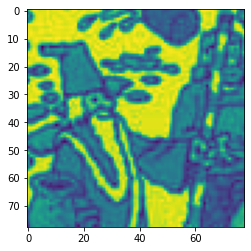

In [29]:
prueba = cv2.imread("c_clue.jpg",cv2.IMREAD_GRAYSCALE)
plt.imshow(prueba)

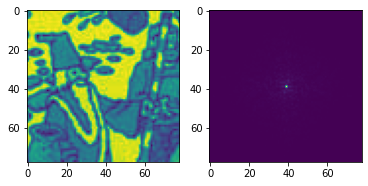

In [30]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(prueba)
ax[1].imshow((np.abs(np.fft.fftshift(np.fft.fftn(prueba)))))

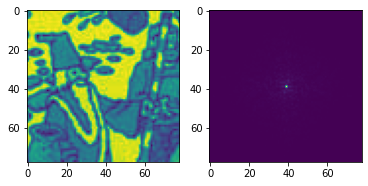

<ipython-input-21-fb5a8488694c>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  dft2d[i,j] +=entrada[m,n]*np.exp((-1j*2*np.pi)*((i*m/ancho) + (j*n/Alto)))


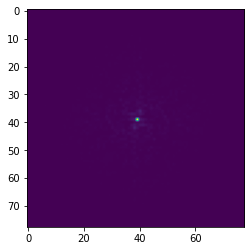

In [31]:
aso = prueba
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(aso))
ax[1].imshow((np.abs(np.fft.fftshift(np.fft.fftn(aso)))))
plt.show()


eso = DFF_2D(aso)
plt.imshow(np.abs(np.fft.fftshift(eso)))
